In [1]:
import numpy as np
from scipy.stats import norm, uniform
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from operator import itemgetter
import emcee 
import corner
import time
import os
from multiprocessing import Pool
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')
ncpu = cpu_count()
print(f"{ncpu} CPUs") 

16 CPUs


In [2]:
from os.path import join, abspath
import sys
from os import pardir, mkdir
import vaex

# import utils
root_dir = abspath(pardir)
sys.path.insert(0, root_dir)
root_data_dir = join(root_dir, "Data")

In [3]:
from utils import log_nu_mod

In [329]:
def plot_chain(sampler, labels, figsize=(10, 7)):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    samples = sampler.get_chain()
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples[:, :, i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

In [5]:
name = "Baryon"
data_dir = join(root_data_dir, name)
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#    components               rho     e_rho    sigma_z    e_sigma_z
0    Molecular gas (H2)       0.0104  0.00312  3.7        0.2
1    Cold atomic gas (HI(1))  0.0277  0.00554  7.1        0.5
2    Warm atomic gas (HI(2))  0.0073  0.0007   22.1       2.4
3    Hot ionized gas (HII)    0.0005  3e-05    39.0       4.0
4    Giant stars              0.0006  6e-05    15.5       1.6
...  ...                      ...     ...      ...        ...
7    4 < MV < 5               0.0029  0.00029  18.0       1.8
8    5 < MV < 8               0.0072  0.00072  18.5       1.9
9    MV > 8                   0.0216  0.0028   18.5       4.0
10   White dwarfs             0.0056  0.001    20.0       5.0
11   Brown dwarfs             0.0015  0.0005   20.0       5.0

In [6]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
sigma_rhos = df_baryon["e_rho"].to_numpy()
sigma_sigmaz = df_baryon["e_sigma_z"].to_numpy()

# Just $\nu(z)$

In [6]:
# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 0 # Msun/pc^2
hDD = 20 # pc
Nu0 = np.exp(5)
zsun = 10 # kpc
sigma_w = 5 # km/s
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 1

zz = np.linspace(-200, 200, 50)

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
logNu_DM = log_nu_mod(zz, theta)

sigmaDD = 7 # Msun/pc^2
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
logNu = log_nu_mod(zz, theta)

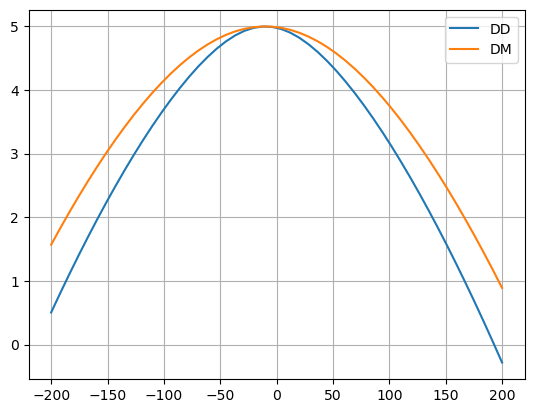

In [7]:
plt.plot(zz, logNu, label="DD")
plt.plot(zz, logNu_DM, label="DM")
plt.grid()
plt.legend()
plt.show()

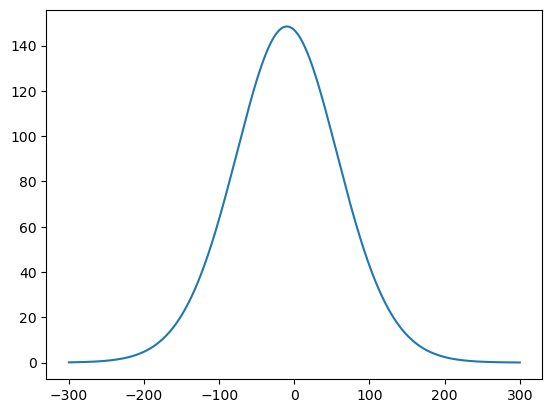

In [227]:
density = lambda z, theta: np.exp(log_nu_mod(z, theta))

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 0 # Msun/pc^2
hDD = 20 # pc
Nu0 = np.exp(5)
zsun = 10 # kpc
sigma_w = 5 # km/s
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
N0 = 1

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)
z = np.linspace(-300, 300, 1000)
nu = density(z, theta)
plt.plot(z, nu)

Vol = 26005.87835150014


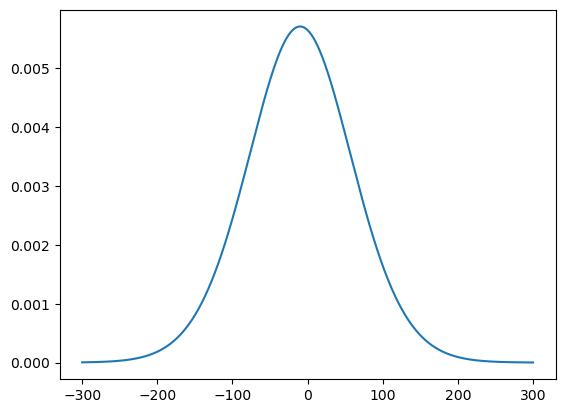

In [228]:
Vol = np.trapz(nu, z)
print("Vol = {0}".format(Vol))

density_pdf = lambda z, theta: density(z, theta)/Vol

nu_pdf = density_pdf(z, theta)

plt.plot(z, nu_pdf)
plt.show()

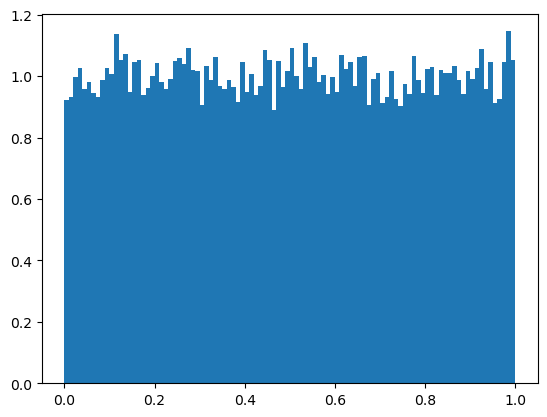

In [229]:
z_rand = np.random.rand(np.floor(Vol).astype(int))
plt.hist(z_rand, bins=100, density=True)
plt.show()

In [12]:
cdf_z = np.cumsum(nu_pdf)
cdf_z /= cdf_z[-1]
cdf_z = np.unique(cdf_z)
zz = z[:len(cdf_z)]

plt.plot(zz, cdf_z)
plt.show()

NameError: name 'nu_pdf' is not defined

In [11]:
inverse_cdf_z = interp1d(cdf_z, zz, kind="quadratic", fill_value="extrapolate")

zs = inverse_cdf_z(z_rand)

plt.hist(zs, bins=100, density=True)
plt.show()

NameError: name 'cdf_z' is not defined

In [232]:
def safe_log(x):
    return np.select([x > 0, x <= 0], [np.log(x), -np.inf])

# histogram
def generate_pdf(z, theta):
  Wz = density(z, theta)
  density_z = interp1d(z, Wz)
  return density_z(z)

def log_likelihood(data, **theta):
  z = data
  znum, zedge, zerr = z
  zmid = (zedge[1:] + zedge[:-1]) / 2
  density_z = generate_pdf(zmid, theta)
  probz = np.nan_to_num(norm.logpdf(znum, loc=density_z, scale=zerr), nan=0)
  return np.sum(probz)
  

In [233]:
# theta_names = ['rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'zsun', 'R', 'sigma_w', 'w0', 'N0']
theta_names = ['zsun', 'R', 'rhoDM', 'Nu0']
theta_uniform = ['zsun']
theta_gaussian = ['R']
theta_log = ['rhoDM', 'Nu0']

# uniform prior
def log_prior(**pars):
  theta, loc, scale = pars['theta'], pars['loc'], pars['scale']
  uniform_args = dict(x=[], loc=[], scale=[])
  for t in theta_uniform:
    uniform_args['x'].append(theta[t])
    uniform_args['loc'].append(loc[t])
    uniform_args['scale'].append(scale[t])
  gaussian_args = dict(x=[], loc=[], scale=[])
  for t in theta_gaussian:
    gaussian_args['x'].append(theta[t])
    gaussian_args['loc'].append(loc[t])
    gaussian_args['scale'].append(scale[t])
  log_args = dict(x=[], loc=[], scale=[])
  for t in theta_log:
    log_args['x'].append(np.log(theta[t]))
    log_args['loc'].append(np.log(loc[t]))
    log_args['scale'].append(np.log(1+scale[t]/loc[t]))

  val_uniform = np.sum(uniform.logpdf(**uniform_args))
  val_gaussian = np.sum(norm.logpdf(**gaussian_args))
  val_log = np.sum(uniform.logpdf(**log_args))
  return val_uniform + val_gaussian + val_log

def log_posterior(x: np.ndarray, data: np.ndarray, priors: dict):
  theta = {t: x[i] for i, t in enumerate(theta_names)}
  pars = dict(theta=theta, **priors)
  log_prior_ = log_prior(**pars)
  if np.isinf(log_prior_) or np.isnan(log_prior_):
    return -np.inf
  theta['sigmaDD'] = 0
  theta['hDD'] = 1
  theta['sigma_w'] = sigma_w
  theta['sigmaz'] = sigmaz
  theta['rhos'] = rhos
  return log_prior_ + log_likelihood(data, **theta)

In [247]:
# test
# ['rhoDM', 'Nu0', 'zsun', 'R', 'sigma_w']

zedge = np.linspace(-200, 200, 50)
dz = zedge[1] - zedge[0]
znum, _ = np.histogram(zs, bins=zedge)
zerr = np.sqrt(znum)
znum, zerr = znum/dz, zerr/dz
data=(znum, zedge, zerr)

loc = dict(zsun=zsun-20, R=3.4E-3, rhoDM=0.001, Nu0=Nu0*.9)
scale = dict(zsun=40, R=0.6E-3, rhoDM=0.03, Nu0=Nu0*.2)
priors=dict(loc=loc, scale=scale)

# rhoDM = 0.016 # Msun/pc^3
# sigmaDD = 0 # Msun/pc^2
# hDD = 20 # pc
# Nu0 = np.exp(5)
# zsun = 10 # kpc
# sigma_w = 5 # km/s
# w0 = -7 # km/s
# R = 3.4E-3 #

theta = np.array([zsun, R, rhoDM, Nu0])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
pars = dict(theta=theta_dict, **priors)
pars

{'theta': {'zsun': 10.0,
  'R': 0.0034,
  'rhoDM': 0.016,
  'Nu0': 148.4131591025766},
 'loc': {'zsun': -10, 'R': 0.0034, 'rhoDM': 0.001, 'Nu0': 133.57184319231894},
 'scale': {'zsun': 40, 'R': 0.0006, 'rhoDM': 0.03, 'Nu0': 29.682631820515322}}

In [248]:
log_prior(**pars)

3.1831309245757016

In [249]:
theta = np.array([zsun, R, rhoDM, Nu0])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
theta_dict['sigmaDD'] = 0
theta_dict['hDD'] = 1
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['sigma_w'] = sigma_w
log_likelihood(data, **theta_dict)

-103.82788379735464

In [250]:
theta = np.array([zsun-10, R, rhoDM, Nu0])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
theta_dict['sigmaDD'] = 0
theta_dict['hDD'] = 1
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['sigma_w'] = sigma_w
log_likelihood(data, **theta_dict)

-356.5914431786669

In [251]:
theta = np.array([zsun, R, rhoDM, Nu0])
log_posterior(theta, data, priors)

-100.64475287277894

In [252]:
theta = np.array([zsun-10, R, rhoDM, Nu0])
log_posterior(theta, data, priors)

-353.4083122540912

In [253]:
loc = priors["loc"]
scale = priors["scale"]

ndim = len(theta_names)
nwalkers = ndim*3

p0 = []
for t in theta_uniform:
  p0.append(np.random.uniform(loc[t], loc[t]+scale[t], size=nwalkers))
for t in theta_gaussian:
  p0.append(np.random.normal(loc[t], scale[t], size=nwalkers))
for t in theta_log:
  p0.append(np.exp(np.random.uniform(np.log(loc[t]), np.log(loc[t]+scale[t]), size=nwalkers)))
p0 = np.array(p0).T
p0

array([[ 2.08956402e+01,  2.58882936e-03,  2.41782202e-03,
         1.53283839e+02],
       [ 5.54851753e+00,  3.59415155e-03,  1.63381058e-02,
         1.44279278e+02],
       [-1.70364249e+00,  3.09780103e-03,  1.59638205e-02,
         1.40606841e+02],
       [ 1.30249941e-01,  2.83733551e-03,  3.38880619e-03,
         1.56473432e+02],
       [ 2.07121120e+01,  3.29275298e-03,  2.22917172e-03,
         1.53318781e+02],
       [-4.51316421e+00,  3.60090234e-03,  1.72428046e-02,
         1.55005092e+02],
       [-1.53273808e+00,  3.29070974e-03,  2.03873924e-03,
         1.45801107e+02],
       [-1.66155755e+00,  2.25854836e-03,  2.22175242e-03,
         1.50930015e+02],
       [ 5.43927560e+00,  3.95502097e-03,  1.76946343e-02,
         1.52371891e+02],
       [ 2.83718603e+01,  4.39138873e-03,  2.36292812e-03,
         1.50536490e+02],
       [ 1.20521862e+01,  3.58984354e-03,  1.94232428e-03,
         1.50427674e+02],
       [-3.10514185e+00,  3.07646106e-03,  1.51918483e-02,
      

100%|██████████| 1000/1000 [01:04<00:00, 15.42it/s]


Multiprocessing took 64.9 seconds


100%|██████████| 1000/1000 [01:05<00:00, 15.33it/s]


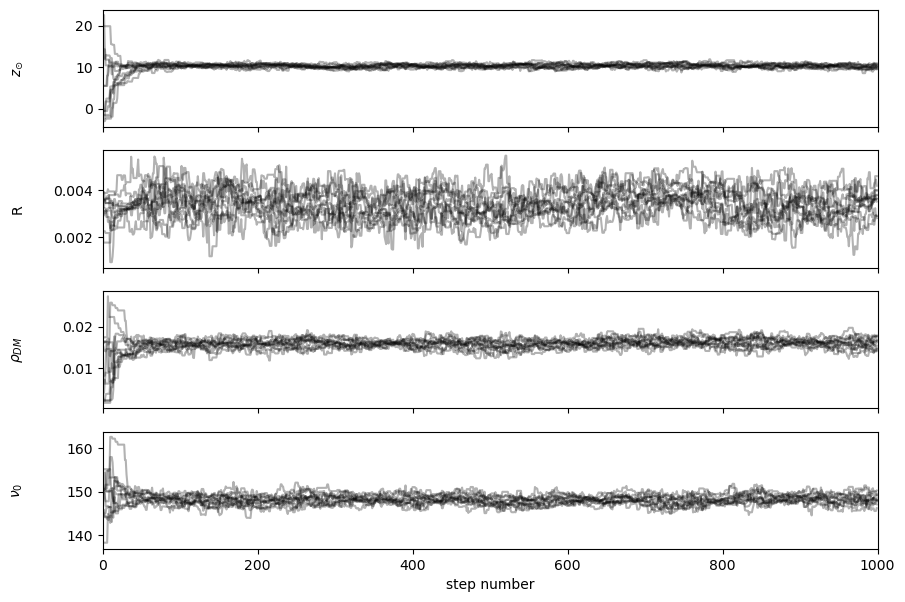

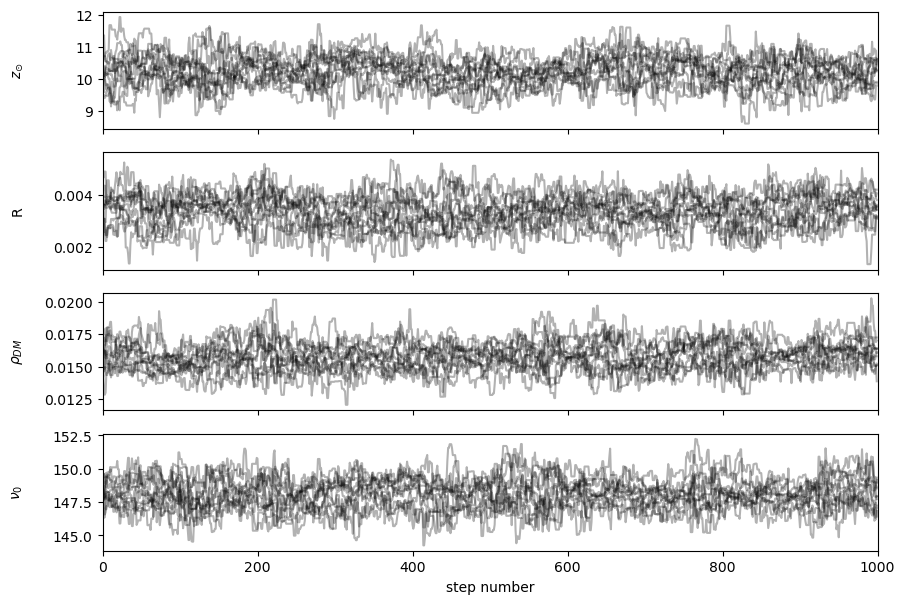

In [254]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
labels = [r"$z_{\odot}$", "R", r"$\rho_{DM}$", r"$\nu_0$"]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, priors])
    start = time.time()
    state = sampler.run_mcmc(p0, 1000, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    plot_chain(sampler, labels)
    sampler.reset()
    sampler.run_mcmc(state, 1000, progress=True)
    plot_chain(sampler, labels)
    sampler_ = sampler

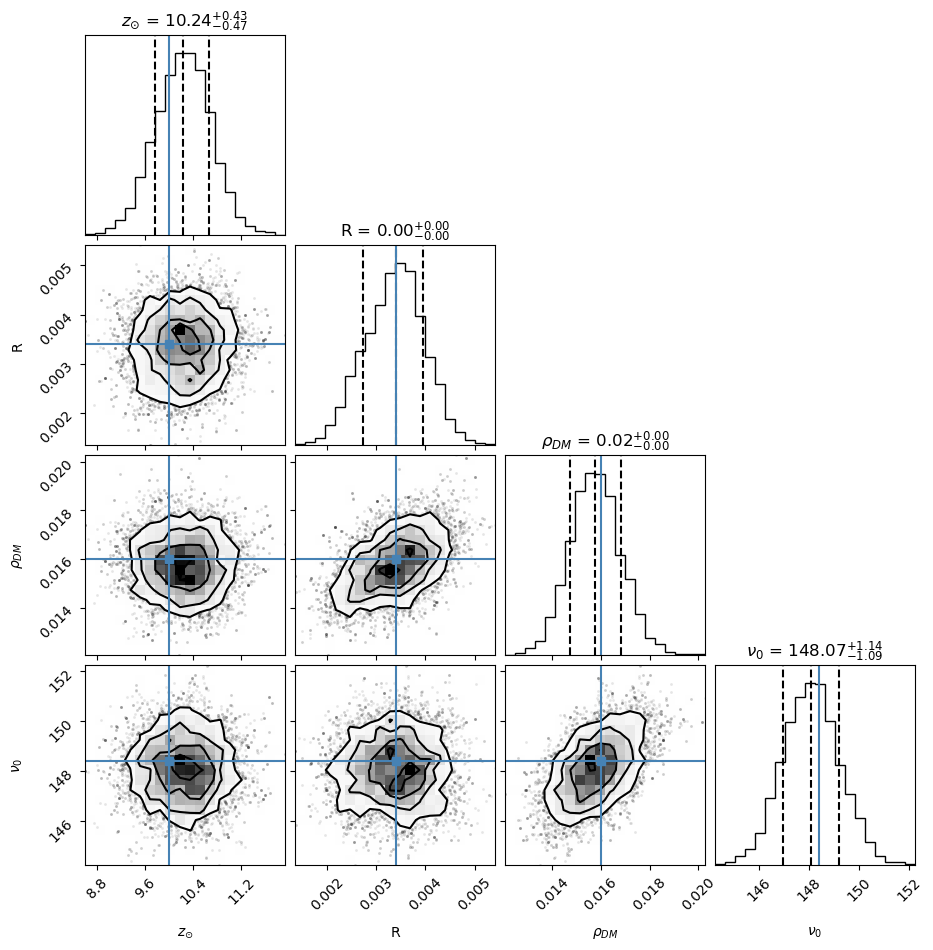

In [255]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(
    flat_samples, labels=labels,
    truths=[zsun, R, rhoDM, Nu0],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

## 2D
$\nu(z)$ and $f_0(w)$

\begin{align*} 
  F(z, w) = \nu(z)\cdot \text{comp}(z)\times\mathcal{N}[w; w_0, \sigma_w(z)]
\end{align*}
Where
\begin{align*} 
  \sigma_w(z) = a(z-z_0)^2+\sigma_{w0}
\end{align*}

10453.93315573603


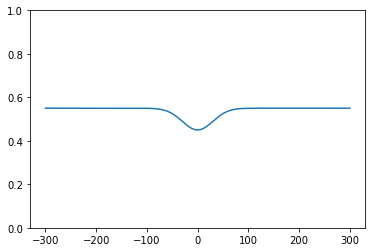

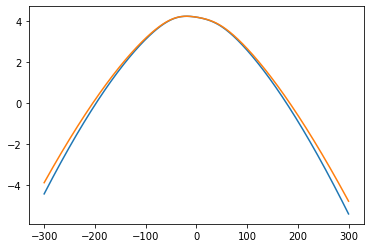

In [377]:
number_density = lambda z, **theta: np.exp(log_nu_mod(z, **theta))

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
# Nu0 = np.exp(6.5)
Nu0 = np.exp(5)
zsun = 10 # kpc
sigma_w = 5 # km/s, is sigma_w0
w0 = -7 # km/s
R = 3.4E-3 # Msun/pc^3
a = 2E-5

theta_dict = dict(zsun=zsun, w0=w0, a=a, R=R,  rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, sigma_w=sigma_w)
z = np.linspace(-300, 300, 1000)
comp = lambda z: -norm.pdf(z, loc=0, scale=30)*np.sqrt(2*np.pi)*30*.1+0.55
nu = number_density(z, **theta_dict)*comp(z)
theta_dict['R'] = 10E-3
nu2 = number_density(z, **theta_dict)*comp(z)
N0 = np.trapz(nu, z)
print(N0)

plt.plot(z, comp(z))
plt.ylim(0, 1)
plt.show()

plt.plot(z, np.log(nu))
plt.plot(z, np.log(nu2))
plt.show()

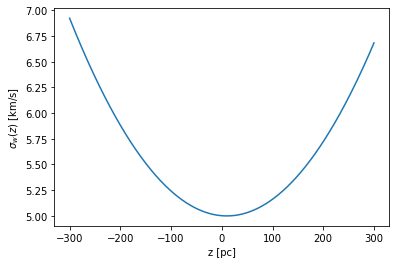

In [276]:
sigma_wz = a*(z-zsun)**2 + sigma_w

plt.plot(z, sigma_wz)
plt.xlabel("z [pc]")
plt.ylabel(r"$\sigma_w(z)$ [km/s]")
plt.show()

In [277]:
def fwz(z, w, **theta):
  sigma_w0, a, zsun, w0 = theta["sigma_w"], theta["a"], theta["zsun"], theta['w0']
  sigma_w = a*(z-zsun)**2 + sigma_w0
  return norm.pdf(w, loc=w0, scale=sigma_w)
w = np.linspace(-30, 30, 1001)
W, Z = np.meshgrid(w, z)
fwz_instance = fwz(Z, W, **theta)

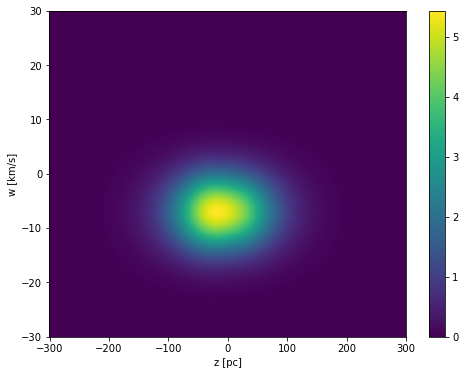

In [278]:
fnu = np.repeat(nu, len(w)).reshape(len(nu), len(w))
F = fwz_instance*fnu

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.pcolormesh(Z, W, F, cmap="viridis")
ax.set_xlabel("z [pc]")
ax.set_ylabel("w [km/s]")
fig.colorbar(im, ax=ax)
plt.show()


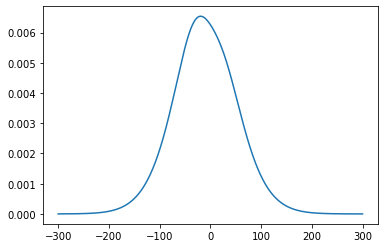

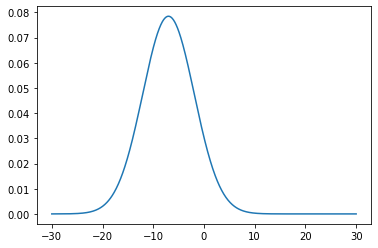

In [279]:
fnu = np.trapz(F, w, axis=1)
Area = np.trapz(fnu, z)
fnu /= Area

plt.plot(z, fnu)
plt.show()

fw = np.trapz(F, z, axis=0)
Area = np.trapz(fw, w)
fw /= Area

plt.plot(w, fw)
plt.show()

In [283]:
Vol = np.trapz(np.trapz(F, z, axis=0), w, axis=0)
print(Vol)

def density(z, w, **theta):
  fnu = number_density(z, **theta)*comp(z)
  fwz_instance = fwz(z, w, **theta)
  return fnu*fwz_instance

def density_pdf(z, w, **theta):
  return density(z,w, **theta)/Vol

10453.894433132215


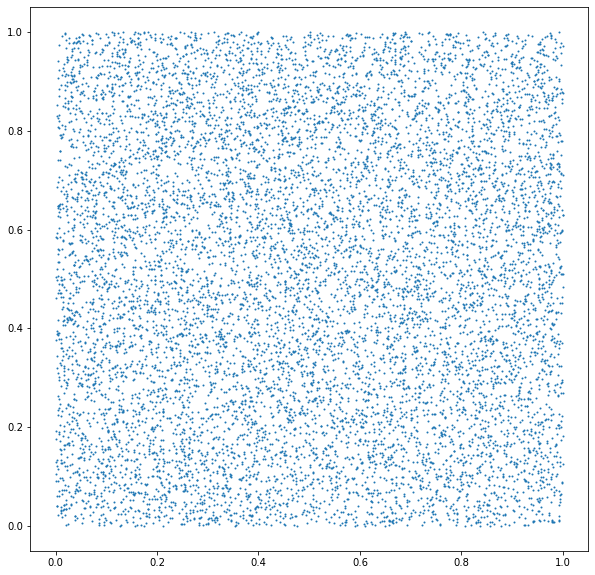

In [281]:
z_rand = np.random.rand(np.floor(Vol).astype(int))
w_rand = np.random.rand(np.floor(Vol).astype(int))

plt.figure(figsize=(10,10))
plt.scatter(z_rand, w_rand, s=1)
plt.show()

In [284]:
W, Z = np.meshgrid(w, z)
Fd = density_pdf(Z, W, **theta)
Fz = np.trapz(Fd, w, axis=1)
cdf_z = np.cumsum(Fz)
cdf_z = cdf_z / cdf_z[-1]
cdf_z_unique = np.unique(cdf_z)
inverse_cdf_z = interp1d(cdf_z_unique, z[:len(cdf_z_unique)], kind='cubic', fill_value='extrapolate')

zs, ws = [], []
for i, (zz, ww) in enumerate(zip(z_rand, w_rand)):
    z_t = inverse_cdf_z(zz)
    Fw = density_pdf(z_t, w, **theta)
    cdf_w = np.cumsum(Fw)
    cdf_w = cdf_w / cdf_w[-1]
    cdf_w_unique = np.unique(cdf_w)
    inverse_cdf_w = interp1d(cdf_w_unique, w[:len(cdf_w_unique)], kind='cubic', fill_value='extrapolate')
    w_t = inverse_cdf_w(ww)
    zs.append(z_t)
    ws.append(w_t)
    if i % 100 == 0:
        print(i, end=' ')
zs = np.array(zs)
ws = np.array(ws)
Fw = np.trapz(Fd, z, axis=0)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 

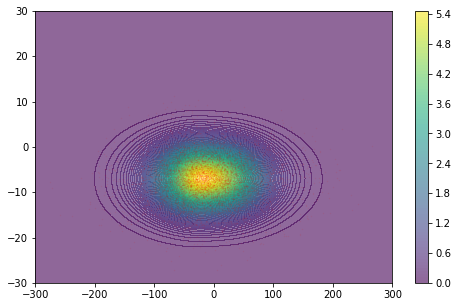

In [285]:
plt.figure(figsize=(8,5))
plt.contourf(Z, W, F, 100, alpha=0.6)
plt.colorbar()
plt.scatter(zs, ws, s=0.1, alpha=0.1, c="r")
plt.show()

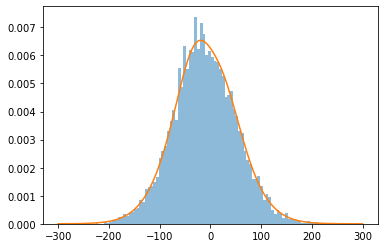

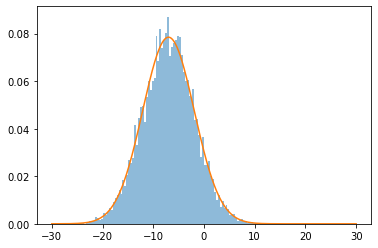

In [286]:
Area = np.trapz(Fz, z)
plt.hist(zs, bins=100, density=True, alpha=0.5)
plt.plot(z, Fz/Area)
plt.show()

Area = np.trapz(Fw, w)
plt.hist(ws, bins=100, density=True, alpha=0.5)
plt.plot(w, Fw/Area)
plt.show()

In [32]:
# histogram
def generate_pdf(x, xdir, xmax, Ntot, **theta):
  t = np.linspace(-1, 1, 1000)
  density_x = []
  for xdirr in xdir:
    z = xmax['z']*t*xdirr['z']
    w = xmax['w']*t*xdirr['w']
    fx = density_pdf(z, w, **theta)
    area = np.trapz(fx, t)
    fx /= area
    density_xx = interp1d(t, fx)
    density_x.append(density_xx(x)*Ntot)
  density_x = np.array(density_x)
  return density_x

def log_likelihood(data, **theta):
  xnum, xedge, xerr, xdir, xmax = data
  xmid = (xedge[1:] + xedge[:-1]) / 2
  dx = xedge[1] - xedge[0]
  Ntot = xnum[0].sum()*dx
  density_x = generate_pdf(xmid, xdir, xmax, Ntot, **theta)
  # for i, (xxnum, xxerr, density_xx) in enumerate(zip(xnum, xerr, density_x)):
  #   plt.bar(xmid, density_xx, width=dx)
  #   plt.errorbar(xmid, xxnum, yerr=xxerr, fmt='.', c="red")
  #   plt.title(i)
  #   plt.show()

  probx = np.nan_to_num(norm.logpdf(xnum, loc=density_x, scale=xerr), nan=0)
  return np.sum(probx)


In [287]:
# histogram

def log_likelihood(data, **theta):
  xnum, xedge, xerr = data
  zedge, wedge = xedge
  zmid = (zedge[1:] + zedge[:-1]) / 2
  wmid = (wedge[1:] + wedge[:-1]) / 2
  dz = zedge[1] - zedge[0]
  dw = wedge[1] - wedge[0]
  Ntot = xnum.sum()
  Wmid, Zmid = np.meshgrid(wmid, zmid)
  
  fx = density_pdf(Zmid, Wmid, **theta)
  fz = np.trapz(fx, wmid, axis=1)
  
  # flatten = (fx*Ntot*dw*dz-xnum).flatten()
  # plt.plot(flatten)
  
  probx = np.nan_to_num(norm.logpdf(xnum, loc=fx*Ntot*dw*dz, scale=xerr), nan=0)
  return np.sum(probx)


In [288]:
# theta_names = ['zsun', 'w0', 'log_a', 'R', 'rhoDM', 'Nu0', 'sigma_w'] # DM only
theta_names = ['zsun', 'w0', 'log_a', 'R', 'rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'sigma_w']
theta_uniform = ['zsun', 'w0', 'log_a']
theta_gaussian = ['R']
theta_log = ['rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'sigma_w']

# uniform prior
def log_prior(**pars):
  theta, loc, scale = pars['theta'], pars['loc'], pars['scale']
  uniform_args = dict(x=[], loc=[], scale=[])
  for t in theta_uniform:
    uniform_args['x'].append(theta[t])
    uniform_args['loc'].append(loc[t])
    uniform_args['scale'].append(scale[t])
  gaussian_args = dict(x=[], loc=[], scale=[])
  for t in theta_gaussian:
    gaussian_args['x'].append(theta[t])
    gaussian_args['loc'].append(loc[t])
    gaussian_args['scale'].append(scale[t])
  log_args = dict(x=[], loc=[], scale=[])
  for t in theta_log:
    log_args['x'].append(np.log(theta[t]))
    log_args['loc'].append(np.log(loc[t]))
    log_args['scale'].append(np.log(1+scale[t]/loc[t]))

  val_uniform = np.sum(uniform.logpdf(**uniform_args))
  val_gaussian = np.sum(norm.logpdf(**gaussian_args))
  val_log = np.sum(uniform.logpdf(**log_args))
  return val_uniform + val_gaussian + val_log

def log_posterior(x: np.ndarray, data: np.ndarray, priors: dict):
  theta = {t: x[i] for i, t in enumerate(theta_names)}
  pars = dict(theta=theta, **priors)
  log_prior_ = log_prior(**pars)
  if np.isinf(log_prior_) or np.isnan(log_prior_):
    return -np.inf
  theta['sigmaz'] = sigmaz
  theta['rhos'] = rhos
  theta['a'] = np.exp(theta['log_a'])
  return log_prior_ + log_likelihood(data, **theta)

In [30]:
# test
# ['zsun', 'w0', 'R', 'rhoDM', 'Nu0', 'sigma_w', 'a']

xnum, xdir, xerr = [], [], []
# angles = [0, np.pi/4, np.pi/2, 3*np.pi/2]
angles = np.linspace(0, np.pi, 3)
angles = angles[:-1]
print(angles)
xedge = np.linspace(-1, 1, 100)
dx = xedge[1]-xedge[0]
print(dx)
xmid = (xedge[:-1]+xedge[1:])/2
for angle in angles:
  zdir = np.cos(angle)
  wdir = np.sin(angle)
  xdir.append(dict(z=zdir, w=wdir))
  xi = zs/z.max()*zdir+ws/w.max()*wdir
  xxnum, _ = np.histogram(xi, bins=xedge)
  xxerr = np.sqrt(xxnum)
  xxnum, xxerr = xxnum/dx, xxerr/dx
  xnum.append(xxnum)
  xerr.append(xxerr)
    
xdir = np.array(xdir)
xnum = np.array(xnum)
xerr = np.array(xerr)

xmax = dict(z=z.max(), w=w.max())

data=(xnum, xedge, xerr, xdir, xmax)

# for xxnum, angle in zip(xnum, angles):
#   plt.step(xmid, xxnum, where='mid', label=np.round(angle,2))
# plt.legend()
# plt.show()

loc = dict(zsun=zsun-20, w0=w0-sigma_w*3, log_a=np.log(a*0.01), R=3.4E-3, rhoDM=0.001, Nu0=Nu0*.9, sigma_w=sigma_w*0.9)
scale = dict(zsun=40, w0=sigma_w*6, log_a=np.log(100/0.01), R=0.6E-3, rhoDM=0.03, Nu0=Nu0*.2, sigma_w=sigma_w*0.2)
priors=dict(loc=loc, scale=scale)

theta = np.array([zsun, w0, np.log(a), R, rhoDM, Nu0, sigma_w])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
pars = dict(theta=theta_dict, **priors)
pars

[0.         1.57079633]
0.02020202020202022


{'theta': {'zsun': 10.0,
  'w0': -7.0,
  'log_a': -10.819778284410283,
  'R': 0.0034,
  'rhoDM': 0.016,
  'Nu0': 13291.297228263233,
  'sigma_w': 5.0},
 'loc': {'zsun': -10,
  'w0': -22,
  'log_a': -15.424948470398375,
  'R': 0.0034,
  'rhoDM': 0.001,
  'Nu0': 11962.16750543691,
  'sigma_w': 4.5},
 'scale': {'zsun': 40,
  'w0': 30,
  'log_a': 9.210340371976184,
  'R': 0.0006,
  'rhoDM': 0.03,
  'Nu0': 2658.2594456526467,
  'sigma_w': 1.0}}

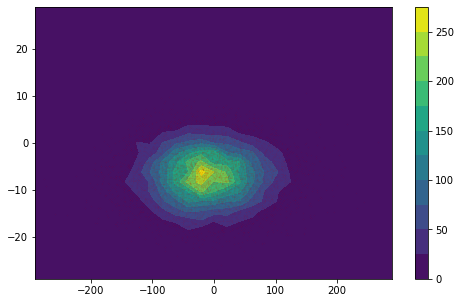

In [289]:
# test
zedge = np.linspace(z.min(), z.max(), 30)
wedge = np.linspace(w.min(), w.max(), 30)

xnum, _ = np.histogramdd((zs, ws), bins=(zedge, wedge))

zmid = (zedge[1:] + zedge[:-1]) / 2
wmid = (wedge[1:] + wedge[:-1]) / 2

Wmid, Zmid = np.meshgrid(wmid, zmid)

plt.figure(figsize=(8,5))
plt.contourf(Zmid, Wmid, xnum, 10)
plt.colorbar()
plt.scatter(zs, ws, s=0.04, alpha=0.1, c="r")
plt.show()

In [290]:
xedge = (zedge, wedge)
xerr = np.sqrt(xnum)

data=(xnum, xedge, xerr)

loc = dict(zsun=zsun-20, w0=w0-sigma_w*3, log_a=np.log(a*0.001), R=3.4E-3, rhoDM=0.0001, sigmaDD=1, hDD=hDD*0.01, Nu0=Nu0*.9, sigma_w=sigma_w*0.9)
scale = dict(zsun=40, w0=sigma_w*6, log_a=np.log(100/0.001), R=0.6E-3, rhoDM=1, sigmaDD=30, hDD=100, Nu0=Nu0*.2, sigma_w=sigma_w*0.2)
priors=dict(loc=loc, scale=scale)

theta = np.array([zsun, w0, np.log(a), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w])
# theta = np.array([zsun, w0, np.log(a), R, rhoDM, 1, hDD, Nu0, sigma_w])
# theta = np.array([zsun, w0, np.log(a), R, rhoDM, Nu0, sigma_w])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}

pars = dict(theta=theta_dict, **priors)
pars

{'theta': {'zsun': 10.0,
  'w0': -7.0,
  'log_a': -10.819778284410283,
  'R': 0.0034,
  'rhoDM': 0.016,
  'sigmaDD': 7.0,
  'hDD': 20.0,
  'Nu0': 148.4131591025766,
  'sigma_w': 5.0},
 'loc': {'zsun': -10,
  'w0': -22,
  'log_a': -17.72753356339242,
  'R': 0.0034,
  'rhoDM': 0.0001,
  'sigmaDD': 1,
  'hDD': 0.2,
  'Nu0': 133.57184319231894,
  'sigma_w': 4.5},
 'scale': {'zsun': 40,
  'w0': 30,
  'log_a': 11.512925464970229,
  'R': 0.0006,
  'rhoDM': 1,
  'sigmaDD': 30,
  'hDD': 100,
  'Nu0': 29.682631820515322,
  'sigma_w': 1.0}}

In [291]:
log_prior(**pars)

-5.103008547329001

In [292]:
theta = np.array([zsun, w0, np.log(a), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w])
# theta = np.array([zsun, w0, np.log(a), R, rhoDM, Nu0, sigma_w])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
# theta_dict['sigmaDD'] = 0
# theta_dict['hDD'] = 1
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['a'] = np.exp(theta_dict['log_a'])
log_likelihood(data, **theta_dict)

-734.2971521624419

In [293]:
theta = np.array([zsun, w0, np.log(a*0.1), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w])
# theta = np.array([zsun, w0, np.log(a*0.1), R, rhoDM, Nu0, sigma_w])
theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
# theta_dict['sigmaDD'] = 0
# theta_dict['hDD'] = 1
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['a'] = np.exp(theta_dict['log_a'])
log_likelihood(data, **theta_dict)

-738.2872676010111

In [294]:
# theta = np.array([zsun, w0, np.log(a), R, rhoDM, Nu0, sigma_w])
theta = np.array([zsun, w0, np.log(a), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w])
log_posterior(theta, data, priors)

-739.4001607097708

In [295]:
# theta = np.array([zsun, w0, np.log(a*.1), R, rhoDM, Nu0, sigma_w])
theta = np.array([zsun, w0, np.log(a*.1), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w])
log_posterior(theta, data, priors)

-743.39027614834

In [296]:
loc = priors["loc"]
scale = priors["scale"]

ndim = len(theta_names)
nwalkers = ndim*2

p0 = []
for t in theta_uniform:
  p0.append(np.random.uniform(loc[t], loc[t]+scale[t], size=nwalkers))
for t in theta_gaussian:
  p0.append(np.random.normal(loc[t], scale[t], size=nwalkers))
for t in theta_log:
  p0.append(np.exp(np.random.uniform(np.log(loc[t]), np.log(loc[t]+scale[t]), size=nwalkers)))
p0 = np.array(p0).T
p0[:5]

array([[ 6.26023028e+00,  2.97410132e+00, -1.23207977e+01,
         3.21886162e-03,  6.24273031e-01,  7.04805142e+00,
         3.80177073e-01,  1.34799409e+02,  5.49303784e+00],
       [ 5.49182592e+00,  1.54520081e+00, -1.22477198e+01,
         3.17138718e-03,  2.22318744e-01,  1.33457629e+01,
         2.00588742e-01,  1.36501491e+02,  5.31076873e+00],
       [ 7.27521606e+00, -2.12225213e+01, -1.20749647e+01,
         1.95060129e-03,  2.15382157e-02,  1.63815453e+01,
         1.41837022e+00,  1.37801022e+02,  4.93306162e+00],
       [-7.37375728e+00,  6.75457102e+00, -6.59396820e+00,
         3.83287050e-03,  5.89713836e-03,  1.19903744e+01,
         3.79093508e-01,  1.36018894e+02,  4.99180739e+00],
       [ 1.03801068e+01, -9.21240502e+00, -1.36140813e+01,
         2.81757031e-03,  1.09890719e-04,  2.49402593e+01,
         5.64126096e+01,  1.48230772e+02,  4.81081082e+00]])

100%|██████████| 1000/1000 [01:57<00:00,  8.54it/s]


Multiprocessing took 117.5 seconds


100%|██████████| 20000/20000 [36:42<00:00,  9.08it/s]


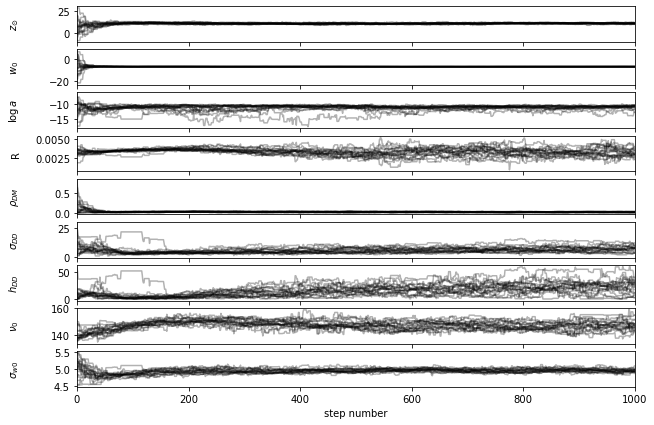

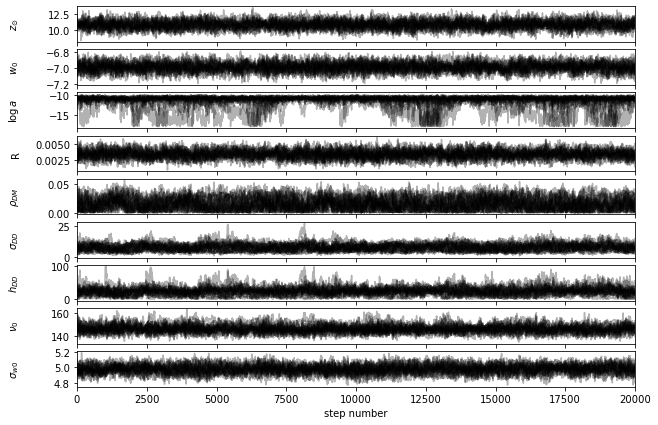

In [297]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
# labels = [r"$z_{\odot}$", r"$w_0$", r"$\log a$", "R", r"$\rho_{DM}$", r"$\nu_0$", r"$\sigma_{w0}$"]
labels = [r"$z_{\odot}$", r"$w_0$", r"$\log a$", "R", r"$\rho_{DM}$", r"$\sigma_{DD}$", r"$h_{DD}$", r"$\nu_0$", r"$\sigma_{w0}$"]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, priors])
    start = time.time()
    state = sampler.run_mcmc(p0, 1000, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    plot_chain(sampler, labels)
    sampler.reset()
    sampler.run_mcmc(state, 20000, progress=True)
    plot_chain(sampler, labels)
    sampler_ = sampler

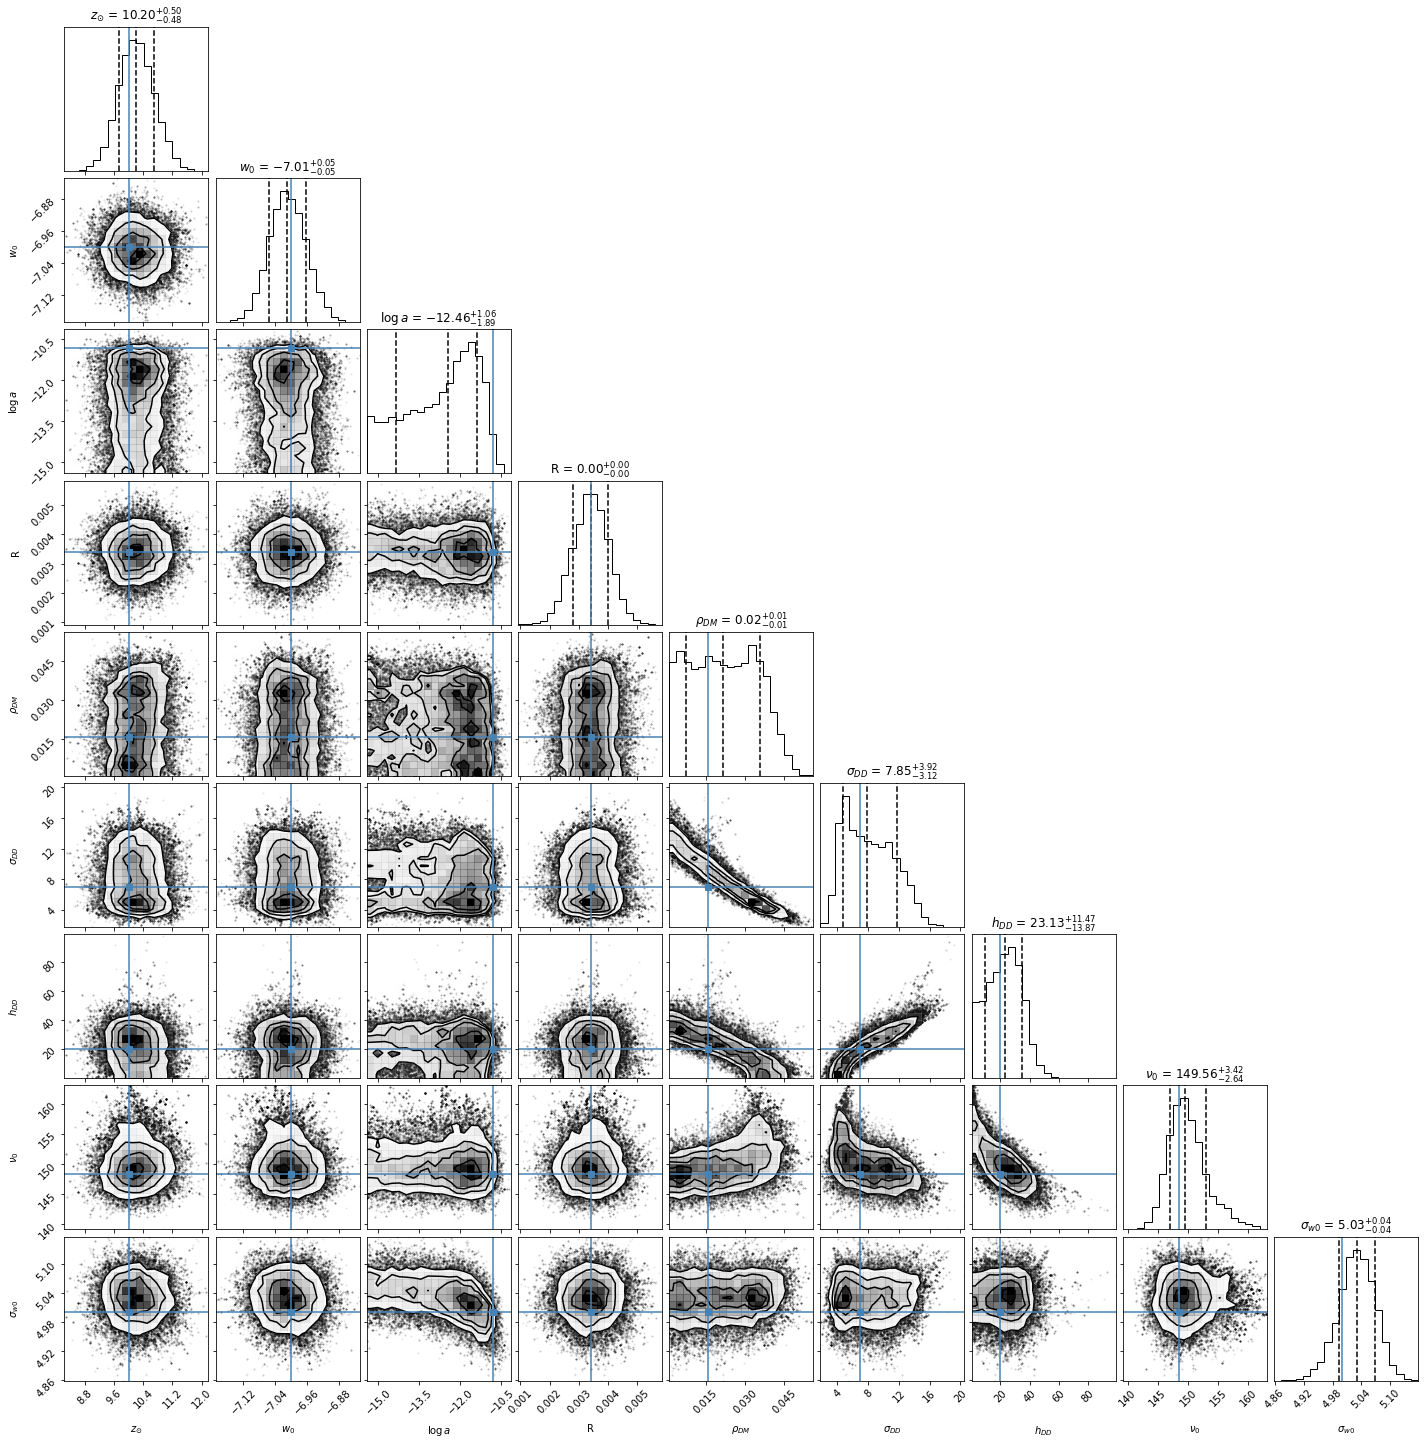

In [189]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(
    flat_samples, labels=labels,
    truths=[zsun, w0, np.log(a), R, rhoDM, sigmaDD, hDD, Nu0, sigma_w],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

# 3D!

\begin{align*} 
  F(z, w, c) = \nu(z)\times\mathcal{N}[w; w_0, \sigma_w(z,c)]
\end{align*}
Where
\begin{align*} 
  \sigma_w(z,c) = a(c)(z+z_0)^2+\sigma_{w0}(c)
\end{align*}
And
\begin{align*} 
  a(c) &= m_ac+a_0 \\
  \sigma_{w0}(c) &= m_{\sigma}c+\sigma_0
\end{align*}

Also
\begin{align*} 
  \nu(z) &= \int \text{d}\nu^*(z, c) \\
  &= \nu_0\int \text{d}A(c) \int \frac{\mathcal{N}(w; w_0, m_{\sigma}c+\sigma_0)\text{ d}w}{\sqrt{w^2-\Phi(z)}}
\end{align*}
where
\begin{align*}
  A(c) = e^{bc}
\end{align*}

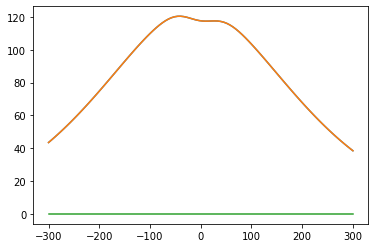

Num 52076.21490398456


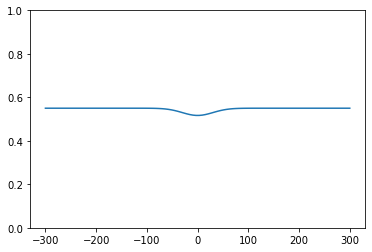

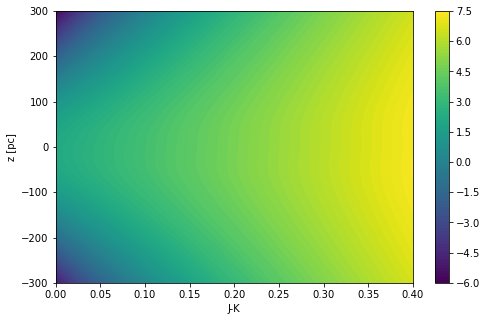

In [549]:
number_density = lambda z, **theta: np.exp(log_nu_mod(z, **theta))
Aexp = lambda b, c: np.exp(b*c)
# uniform
zsun = 10 # kpc
w0 = -7 # km/s
a0 = 2E-5
log_a = np.log(a0)
# gaussian
R = 3.4E-3 # Msun/pc^3
# log
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 1E-3 # Msun/pc^2
hDD = 20 # pc
# Nu0 = np.exp(0)
Nu0 = np.exp(2.8)
sigma_0 = 5 # km/s
# tan
ma = 1E-5
msigma = 25
b = 13


theta_dict = dict(zsun=zsun, w0=w0, a0=a0, R=R, rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD,
                  hDD=hDD, Nu0=Nu0, sigma_0=sigma_0, ma=ma, msigma=msigma, b=b)

z = np.linspace(-300, 300, 100) # height, pc
cmin, cmax = 0, 0.4
c = np.linspace(cmin, cmax, 100) # color, J-K
dc = c[1]-c[0]

CC, ZZ = np.meshgrid(c, z)
comp = lambda z: -norm.pdf(z, loc=0, scale=30)*np.sqrt(2*np.pi)*10*.1+0.55
# comp = lambda z: 1

def nu_zc(z, c, **theta):
  b = theta['b']
  theta['sigma_w'] = theta['msigma']*c+theta['sigma_0']
  # nu_z = number_density(z, **theta)*comp(z)*Aexp(b, c, cmin, cmax) 
  nu_z = number_density(z, **theta)*Aexp(b, c)*comp(z) 
  return nu_z
    
nu_zc_ins = nu_zc(ZZ, CC, **theta_dict)
theta_dict['ma'] = -0.9
nu_zc_ins2 = nu_zc(ZZ, CC, **theta_dict)

nu_z = np.trapz(nu_zc_ins, c, axis=1)
nu_z2 = np.trapz(nu_zc_ins2, c, axis=1)

plt.plot(z, nu_z)
plt.plot(z, nu_z2)
plt.plot(z, nu_z-nu_z2)
plt.show()

N0=np.trapz(nu_z, z)
print("Num", N0)
plt.plot(z, comp(z))
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8,5))
plt.contourf(CC.T,ZZ.T, np.log(nu_zc_ins.T), 100)
plt.ylabel('z [pc]')
plt.xlabel('J-K')
plt.colorbar()
plt.show()

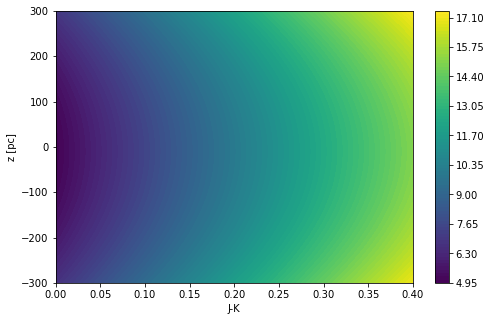

In [510]:
sigma_w = lambda c, msigma, sigma_0: msigma*c+sigma_0
a = lambda c, ma, a0: ma*c+a0

sigma_zc = a(CC, ma, a0)*(ZZ+zsun)**2 + sigma_w(CC, msigma, sigma_0)

plt.figure(figsize=(8,5))
plt.contourf(CC.T, ZZ.T, sigma_zc.T, 100)
plt.colorbar()
plt.ylabel('z [pc]')
plt.xlabel('J-K')
plt.show()

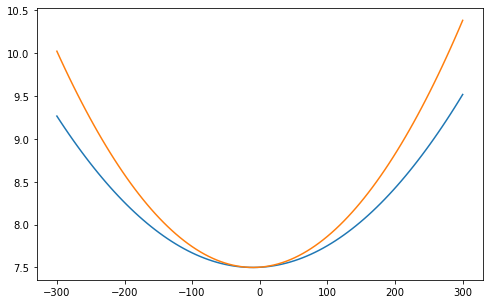

In [522]:
sigma_w = lambda c, msigma, sigma_0: msigma*c+sigma_0
a = lambda c, ma, a0: ma*c+a0

sigma_z = a(0.1, ma, a0)*(z+zsun)**2 + sigma_w(0.1, msigma, sigma_0)
sigma_z2 = a(0.1, np.tan(1E-4), a0)*(z+zsun)**2 + sigma_w(0.1, msigma, sigma_0)

plt.figure(figsize=(8,5))
plt.plot(z, sigma_z)
plt.plot(z, sigma_z2)
plt.show()

In [396]:
w = np.linspace(-30, 30, 100)
W, C, Z = np.meshgrid(w, c, z)

# zz = z[0, 0, :]
# cc = c[:, 0, 0]

def fzwc(z, w, c, **theta):
  theta['sigma_w'] = sigma_w(c, theta['msigma'], theta['sigma_0'])
  nu_zc_ins = nu_zc(z, c, **theta)
  sigmaw = a(c, theta['ma'], theta['a0'])*(z+zsun)**2 + theta['sigma_w']
  result = nu_zc_ins*norm.pdf(w, loc=theta['w0'], scale=sigmaw)
  return result

F = fzwc(Z, W, C, **theta_dict)
Integral = np.trapz(np.trapz(np.trapz(F, z, axis=0), w, axis=0), c, axis=0)
Integral

49244.70778640156

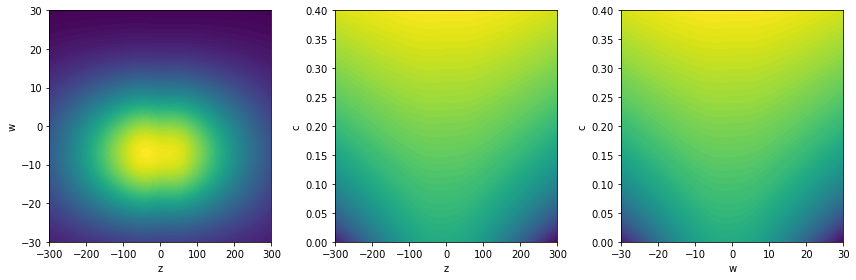

In [397]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
Fzw = np.trapz(F, c, axis=0)
axes[0].contourf(Z[0, :, :], W[0, :, :], Fzw, 100)
axes[0].set_xlabel('z')
axes[0].set_ylabel('w')
Fzc = np.trapz(F, w, axis=1)
axes[1].contourf(Z[:, 0, :], C[:, 0, :], np.log(Fzc), 100)
axes[1].set_xlabel('z')
axes[1].set_ylabel('c')
Fwc = np.trapz(F, w, axis=1)
axes[2].contourf(W[:, :, 0], C[:, :, 0], np.log(Fwc), 100)
axes[2].set_xlabel('w')
axes[2].set_ylabel('c')
plt.tight_layout()
plt.show()

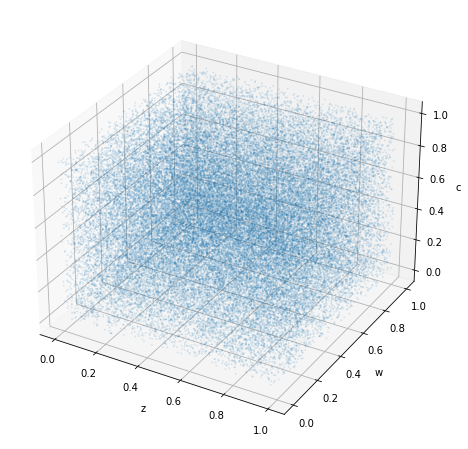

In [235]:
def density_pdf(z, w, c, **theta):
  return fzwc(z, w, c, **theta)/Integral

z_rand = np.random.rand(np.floor(N0).astype(int))
w_rand = np.random.rand(np.floor(N0).astype(int))
c_rand = np.random.rand(np.floor(N0).astype(int))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_rand, w_rand, c_rand, s=1, alpha=0.1)
ax.set_xlabel("z")
ax.set_ylabel("w")
ax.set_zlabel("c")
plt.show()

In [114]:
Fd = density_pdf(Z, W, C, **theta_dict)
Fz = np.trapz(np.trapz(Fd, c, axis=0), w, axis=0)
cdf_z = np.cumsum(Fz)
cdf_z = cdf_z / cdf_z[-1]
cdf_z_unique = np.unique(cdf_z)
inverse_cdf_z = interp1d(cdf_z_unique, z[:len(cdf_z_unique)], kind='cubic', fill_value='extrapolate')

CC, WW = np.meshgrid(c, w)

zs, ws, cs = [], [], []
for i, (zz, ww, cc) in enumerate(zip(z_rand, w_rand, c_rand)):
    z_t = inverse_cdf_z(zz)
    Fwc = density_pdf(z_t, WW, CC, **theta_dict)
    Fw = np.trapz(Fwc, c, axis=1)
    cdf_w = np.cumsum(Fw)
    cdf_w = cdf_w / cdf_w[-1]
    cdf_w_unique = np.unique(cdf_w)
    inverse_cdf_w = interp1d(cdf_w_unique, w[:len(cdf_w_unique)], kind='cubic', fill_value='extrapolate')
    w_t = inverse_cdf_w(ww)
    Fc = density_pdf(z_t, w_t, c, **theta_dict)
    cdf_c = np.cumsum(Fc)
    cdf_c = cdf_c / cdf_c[-1]
    cdf_c_unique = np.unique(cdf_c)
    inverse_cdf_c = interp1d(cdf_c_unique, c[:len(cdf_c_unique)], kind='cubic', fill_value='extrapolate')
    c_t =inverse_cdf_c(cc)
    zs.append(z_t)
    ws.append(w_t)
    cs.append(c_t)
    if i % 100 == 0: print(i, end=' ')
zs = np.array(zs)
ws = np.array(ws)
cs = np.array(cs)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

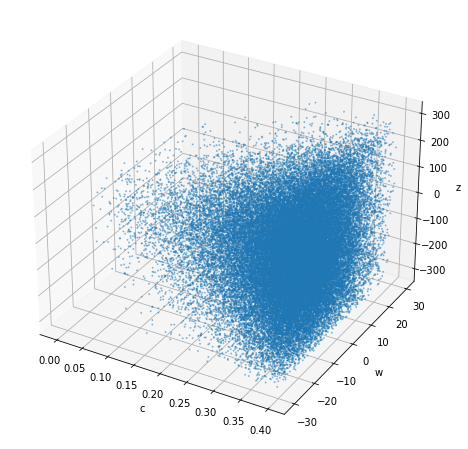

In [370]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cs, ws, zs, s=1, alpha=0.4)
ax.set_zlabel("z")
ax.set_xlabel("c")
ax.set_ylabel("w")
plt.show()

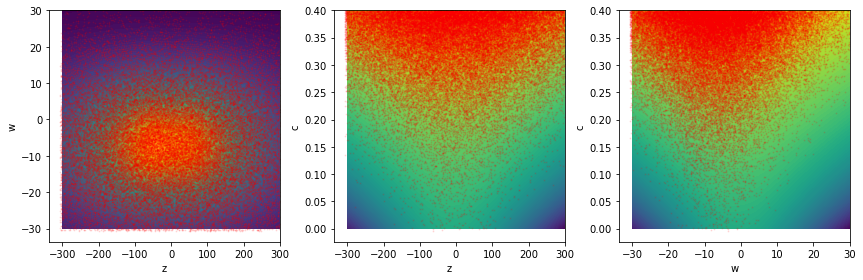

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
Fzw = np.trapz(F, c, axis=0)
axes[0].contourf(Z[0, :, :], W[0, :, :], Fzw, 100)
axes[0].scatter(zs, ws, s=1, alpha=0.1, c="red")
axes[0].set_xlabel('z')
axes[0].set_ylabel('w')
Fzc = np.trapz(F, w, axis=1)
axes[1].contourf(Z[:, 0, :], C[:, 0, :], np.log(Fzc), 100)
axes[1].scatter(zs, cs, s=1, alpha=0.1, c="red")
axes[1].set_xlabel('z')
axes[1].set_ylabel('c')
Fwc = np.trapz(F, w, axis=1)
axes[2].contourf(W[:, :, 0], C[:, :, 0], np.log(Fwc), 100)
axes[2].scatter(ws, cs, s=1, alpha=0.1, c="red")
axes[2].set_xlabel('w')
axes[2].set_ylabel('c')
plt.tight_layout()
plt.show()


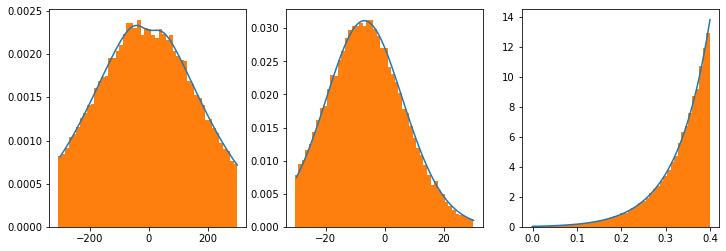

In [118]:
Fzw = np.trapz(F, c, axis=0)
Fz = np.trapz(Fzw, w, axis=0)
area = np.trapz(Fz, z)
Fz /= area
Fw = np.trapz(Fzw, z, axis=1)
area = np.trapz(Fw, w)
Fw /= area
Fc = np.trapz(np.trapz(F, z, axis=2), w, axis=1)
area = np.trapz(Fc, c)
Fc /= area
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(z, Fz)
axes[0].hist(zs, bins=50, density=True)
axes[1].plot(w, Fw)
axes[1].hist(ws, bins=50, density=True)
axes[2].plot(c, Fc)
axes[2].hist(cs, bins=50, density=True)
plt.show()

In [242]:
# theta_ = {'zsun': 10.0, 'w0': -7.0, 'log_a0': -10.819778284410283, 'log_rhoDM': -4.135166556742356, 
#           'log_sigmaDD': -6.907755278982137, 'log_hDD': 2.995732273553991, 'log_Nu0': 2.8, 
#           'log_sigma_0': 1.6094379124341003, 'atan_ma': 9.999999999666668e-06, 
#           'atan_msigma': 1.5308176396716067, 'atan_b': 1.4940244355251187, 'R': 0.0034, 
#           'sigmaz': np.array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,20. ]), 
#           'rhos': np.array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,0.0072, 0.0216, 0.0056, 0.0015]), 
#           'a0': 1.9999999999999998e-05, 'rhoDM': 0.015999999999999997, 'sigmaDD': 0.0010000000000000002, 
#           'hDD': 19.999999999999996, 'Nu0': 16.444646771097048, 'sigma_0': 4.999999999999999, 'ma': 1e-05, 
#           'msigma': 25.000000000000057, 'b': 13.000000000000012}
# F = density_pdf(Z, W, C, **theta_)
# F.sum()
# # 70.71348018082001

In [301]:
# histogram

def log_likelihood(data, **theta):
  xnum, xedge, xerr = data
  zedge, wedge, cedge = xedge
  zmid = (zedge[1:] + zedge[:-1]) / 2
  wmid = (wedge[1:] + wedge[:-1]) / 2
  cmid = (cedge[1:] + cedge[:-1]) / 2
  dz = zedge[1] - zedge[0]
  dw = wedge[1] - wedge[0]
  dc = cedge[1] - cedge[0]
  
  Ntot = xnum.sum()
  
  Wmid, Cmid, Zmid = np.meshgrid(wmid, cmid, zmid)
  
  F = density_pdf(Zmid, Wmid, Cmid, **theta)
  
  # Fzw = np.trapz(F, cmid, axis=0)
  # Fz = np.trapz(Fzw, wmid, axis=0)
  # area = np.trapz(Fz, zmid)
  # Fz /= area
  # Fw = np.trapz(Fzw, zmid, axis=1)
  # area = np.trapz(Fw, wmid)
  # Fw /= area
  # Fc = np.trapz(np.trapz(F, zmid, axis=2), wmid, axis=1)
  # area = np.trapz(Fc, cmid)
  # Fc /= area
  
  # print(np.sum(xnum, axis=(0,1,2)))
  # print(np.sum(xnum, axis=(0,1)))
  # fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  # axes[0].bar(zmid, np.sum(xnum, axis=(0,1)), width=dz)
  # axes[0].plot(zmid, Fz*Ntot*dz, c='red')
  # axes[1].bar(wmid, np.sum(xnum, axis=(0,2)), width=dw)
  # axes[1].plot(wmid, Fw*Ntot*dw, c='red')
  # axes[2].bar(cmid, np.sum(xnum, axis=(1,2)), width=dc)
  # axes[2].plot(cmid, Fc*Ntot*dc, c='red')
  # plt.show()
  
  # fz = np.trapz(fx, wmid, axis=1)
  # zwnum = np.trapz(xnum, cmid, axis=0)
  # zwerr = np.sqrt(zwnum)
  # diff = F*Ntot*dw*dz*dc-xnum
  # diff_zw = np.trapz(diff, cmid, axis=0)
  # plt.figure(figsize=(8,5))
  # plt.contourf(Zmid[0, :, :], Wmid[0, :, :], diff_zw, 100)
  # plt.colorbar()
  # plt.ylabel('z [pc]')
  # plt.xlabel('J-K')
  # plt.show()
  # flatten = (F*Ntot*dw*dz*dc-xnum).flatten()
  # plt.plot(flatten)
  # print(xnum.size)
  probx = np.nan_to_num(norm.logpdf(xnum, loc=F*Ntot*dw*dz*dc, scale=xerr), nan=0)
  # probx = np.nan_to_num(norm.logpdf(xnum, loc=F*Ntot*dw*dz, scale=xerr), nan=0)
  return np.sum(probx)

In [303]:
# # theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(sigmaDD), np.log(hDD), np.log(Nu0), 
# #                   np.log(sigma_0), np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

# theta = np.array([zsun, w0,])
# theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
# theta_dict['sigmaz'] = sigmaz
# theta_dict['rhos'] = rhos
# theta_dict['a0'] = a0 #np.exp(theta['log_a0'])
# theta_dict['rhoDM'] = rhoDM #np.exp(theta['log_rhoDM'])
# theta_dict['sigmaDD'] = sigmaDD #np.exp(theta['log_sigmaDD'])
# theta_dict['hDD'] = hDD #np.exp(theta['log_hDD'])
# theta_dict['Nu0'] = Nu0 #np.exp(theta['log_Nu0'])
# theta_dict['sigma_0'] = sigma_0 #np.exp(theta['log_sigma_0'])
# theta_dict['ma'] = ma #np.tan(theta['atan_ma'])
# theta_dict['msigma'] = msigma #np.tan(theta['atan_msigma'])
# theta_dict['b'] = b #np.tan(theta['atan_b'])
# log_likelihood(data, **theta_dict)

-9761.912590294969

In [534]:
# theta_dict = dict(zsun=zsun, w0=w0, a0=a0, R=R, rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD,
#                   hDD=hDD, Nu0=Nu0, sigma_0=sigma_0, ma=ma, msigma=msigma, b=b)

# theta_uniform = ['zsun', 'w0', 'log_a0', 'log_rhoDM', 'log_sigmaDD', 'log_hDD', 'log_Nu0', 'log_sigma_0',
                 # 'atan_ma', 'atan_msigma', 'atan_b']
theta_uniform = ['zsun', 'w0', 'log_a0', 'log_rhoDM', 'log_Nu0', 'log_sigma_0',
                 'atan_ma', 'atan_msigma', 'atan_b']
theta_gaussian = ['R']

theta_names = theta_uniform + theta_gaussian

# uniform prior
def log_prior(**pars):
  theta, loc, scale = pars['theta'], pars['loc'], pars['scale']
  uniform_args = dict(x=[], loc=[], scale=[])
  for t in theta_uniform:
    uniform_args['x'].append(theta[t])
    uniform_args['loc'].append(loc[t])
    uniform_args['scale'].append(scale[t])
  gaussian_args = dict(x=[], loc=[], scale=[])
  for t in theta_gaussian:
    gaussian_args['x'].append(theta[t])
    gaussian_args['loc'].append(loc[t])
    gaussian_args['scale'].append(scale[t])
  val_uniform = np.sum(uniform.logpdf(**uniform_args))
  val_gaussian = np.sum(norm.logpdf(**gaussian_args))
  return val_uniform + val_gaussian 

def log_posterior(x: np.ndarray, data: np.ndarray, priors: dict):
  theta = {t: x[i] for i, t in enumerate(theta_names)}
  pars = dict(theta=theta, **priors)
  log_prior_ = log_prior(**pars)
  if np.isinf(log_prior_) or np.isnan(log_prior_):
    return -np.inf
  theta['sigmaz'] = sigmaz
  theta['rhos'] = rhos
  # theta['R'] = R
  # theta['a0'] = a0
  theta['a0'] = np.exp(theta['log_a0'])
  # theta['rhoDM'] = rhoDM 
  theta['rhoDM'] = np.exp(theta['log_rhoDM'])
  theta['sigmaDD'] = sigmaDD 
  # theta['sigmaDD'] = np.exp(theta['log_sigmaDD'])
  theta['hDD'] = hDD 
  # theta['hDD'] = np.exp(theta['log_hDD'])
  # theta['Nu0'] = Nu0
  theta['Nu0'] = np.exp(theta['log_Nu0'])
  # theta['sigma_0'] = sigma_0 
  theta['sigma_0'] = np.exp(theta['log_sigma_0'])
  # theta['ma'] = ma 
  theta['ma'] = np.tan(theta['atan_ma'])
  # theta['msigma'] = msigma
  theta['msigma'] = np.tan(theta['atan_msigma'])
  # theta['b'] = b 
  theta['b'] = np.tan(theta['atan_b'])
  return log_prior_ + log_likelihood(data, **theta)

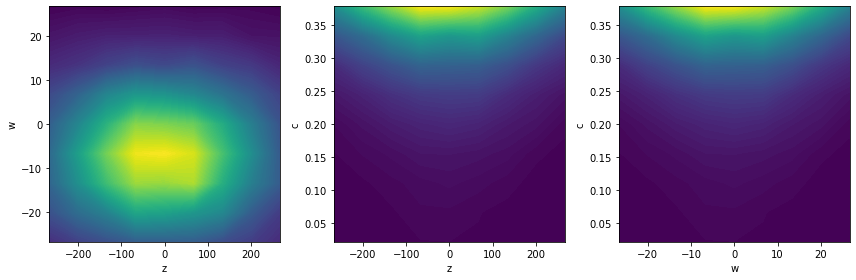

In [435]:
# test
zedge = np.linspace(z.min(), z.max(), 10)
wedge = np.linspace(w.min(), w.max(), 10)
cedge = np.linspace(c.min(), c.max(), 10)

xnum, _ = np.histogramdd((cs, ws, zs), bins=(cedge, wedge, zedge))

zmid = (zedge[1:] + zedge[:-1]) / 2
wmid = (wedge[1:] + wedge[:-1]) / 2
cmid = (cedge[1:] + cedge[:-1]) / 2

Wmid, Cmid, Zmid = np.meshgrid(wmid, cmid, zmid)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
Fzw = np.trapz(xnum, cmid, axis=0)
axes[0].contourf(Zmid[0, :, :], Wmid[0, :, :], Fzw, 100)
axes[0].set_xlabel('z')
axes[0].set_ylabel('w')
Fzc = np.trapz(xnum, wmid, axis=1)
axes[1].contourf(Zmid[:, 0, :], Cmid[:, 0, :], Fzc, 100)
axes[1].set_xlabel('z')
axes[1].set_ylabel('c')
Fwc = np.trapz(xnum, wmid, axis=1)
axes[2].contourf(Wmid[:, :, 0], Cmid[:, :, 0], Fwc, 100)
axes[2].set_xlabel('w')
axes[2].set_ylabel('c')
plt.tight_layout()
plt.show()

In [557]:
2*np.arctan(msigma)-np.pi/2, np.pi/2-np.arctan(msigma)

(1.4908389525483168, 0.03997868712328989)

In [608]:
xedge = (zedge, wedge, cedge)
xerr = np.sqrt(xnum)

data=(xnum, xedge, xerr)

# loc = dict(zsun=zsun-20, w0=w0-sigma_0*9, log_a0=np.log(a0*0.001), log_rhoDM=np.log(0.0001), 
#            log_sigmaDD=np.log(sigmaDD*0.1), log_hDD=np.log(1), log_Nu0=np.log(Nu0*.1), log_sigma_0=np.log(sigma_0*.01), 
#            atan_ma=-np.pi/2, atan_msigma=-np.pi/2, atan_b=-np.pi/2, R=3.4E-3)
# scale = dict(zsun=40, w0=sigma_0*18, log_a0=np.log(1000/0.001), log_rhoDM=np.log(0.1/0.0001), 
#              log_sigmaDD=np.log(100/0.1), log_hDD=np.log(100/1), log_Nu0=np.log(10/0.1), 
#              log_sigma_0=np.log(100/0.01), atan_ma=np.pi, atan_msigma=np.pi, atan_b=np.pi, R=0.6E-3)

loc = dict(zsun=zsun-20, w0=w0-sigma_0*5, log_a0=np.log(a0*0.1), log_rhoDM=np.log(0.001),
           log_Nu0=np.log(Nu0*.1), log_sigma_0=np.log(sigma_0*.1), atan_ma=0, 
           atan_msigma=2*np.arctan(msigma)-np.pi/2, atan_b=2*np.arctan(b)-np.pi/2, R=3.4E-3)
scale = dict(zsun=40, w0=sigma_0*10, log_a0=np.log(100/0.1), log_rhoDM=np.log(0.1/0.001),
             log_Nu0=np.log(3/0.1), log_sigma_0=np.log(2/0.1), atan_ma=1E-4, 
             atan_msigma=2*(np.pi/2-np.arctan(msigma)), atan_b=2*(np.pi/2-np.arctan(b)), R=0.6E-3)

priors=dict(loc=loc, scale=scale)

# theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(sigmaDD), np.log(hDD), np.log(Nu0), 
#                   np.log(sigma_0), np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(Nu0), np.log(sigma_0), 
                  np.arctan(ma), np.arctan(msigma), np.arctan(b), R])
# theta = np.array([R])

theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}

pars = dict(theta=theta_dict, **priors)
pars

{'theta': {'zsun': 10.0,
  'w0': -7.0,
  'log_a0': -10.819778284410283,
  'log_rhoDM': -4.135166556742356,
  'log_Nu0': 2.8,
  'log_sigma_0': 1.6094379124341003,
  'atan_ma': 9.999999999666668e-06,
  'atan_msigma': 1.5308176396716067,
  'atan_b': 1.4940244355251187,
  'R': 0.0034},
 'loc': {'zsun': -10,
  'w0': -32,
  'log_a0': -13.122363377404328,
  'log_rhoDM': -6.907755278982137,
  'log_Nu0': 0.49741490700595425,
  'log_sigma_0': -0.6931471805599453,
  'atan_ma': 0,
  'atan_msigma': 1.4908389525483168,
  'atan_b': 1.4172525442553408,
  'R': 0.0034},
 'scale': {'zsun': 40,
  'w0': 50,
  'log_a0': 6.907755278982137,
  'log_rhoDM': 4.605170185988092,
  'log_Nu0': 3.4011973816621555,
  'log_sigma_0': 2.995732273553991,
  'atan_ma': 0.0001,
  'atan_msigma': 0.07995737424657978,
  'atan_b': 0.1535437825395558,
  'R': 0.0006}}

In [607]:
log_prior(**pars)

6.727970813767161

In [584]:
# theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(sigmaDD), np.log(hDD), np.log(Nu0), 
#                   np.log(sigma_0), np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(Nu0), np.log(sigma_0), 
                  np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['R'] = R
# theta_dict['a0'] = a0
theta_dict['a0'] = np.exp(theta_dict['log_a0'])
# theta_dict['rhoDM'] = rhoDM 
theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
theta_dict['sigmaDD'] = sigmaDD 
# theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
theta_dict['hDD'] = hDD 
# theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
# theta_dict['Nu0'] = Nu0
theta_dict['Nu0'] = np.exp(theta_dict['log_Nu0'])
# theta_dict['sigma_0'] = sigma_0 
theta_dict['sigma_0'] = np.exp(theta_dict['log_sigma_0'])
# theta_dict['ma'] = ma 
theta_dict['ma'] = np.tan(theta_dict['atan_ma'])
# theta_dict['msigma'] = msigma
theta_dict['msigma'] = np.tan(theta_dict['atan_msigma'])
# theta_dict['b'] = b 
theta_dict['b'] = np.tan(theta_dict['atan_b'])
log_likelihood(data, **theta_dict)

-1793.0911231753112

In [576]:
theta = np.array([zsun-5, w0, np.log(a0), np.log(rhoDM), np.log(Nu0), np.log(sigma_0), 
                  np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

theta_dict = {t: theta[i] for i, t in enumerate(theta_names)}
theta_dict['sigmaz'] = sigmaz
theta_dict['rhos'] = rhos
theta_dict['R'] = R
# theta_dict['a0'] = a0
theta_dict['a0'] = np.exp(theta_dict['log_a0'])
# theta_dict['rhoDM'] = rhoDM 
theta_dict['rhoDM'] = np.exp(theta_dict['log_rhoDM'])
theta_dict['sigmaDD'] = sigmaDD 
# theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
theta_dict['hDD'] = hDD 
# theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
# theta_dict['Nu0'] = Nu0
theta_dict['Nu0'] = np.exp(theta_dict['log_Nu0'])
# theta_dict['sigma_0'] = sigma_0 
theta_dict['sigma_0'] = np.exp(theta_dict['log_sigma_0'])
# theta_dict['ma'] = ma 
theta_dict['ma'] = np.tan(theta_dict['atan_ma'])
# theta_dict['msigma'] = msigma
theta_dict['msigma'] = np.tan(theta_dict['atan_msigma'])
# theta_dict['b'] = b 
theta_dict['b'] = np.tan(theta_dict['atan_b'])
log_likelihood(data, **theta_dict)

-1804.4135516620581

In [577]:
# theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(sigmaDD), np.log(hDD), np.log(Nu0), 
#                   np.log(sigma_0), np.arctan(ma), np.arctan(msigma), np.arctan(b), R])

theta = np.array([zsun, w0, np.log(a0), np.log(rhoDM), np.log(Nu0), np.log(sigma_0), 
                  np.arctan(ma), np.arctan(msigma), np.arctan(b), R])
log_posterior(theta, data, priors)

-1787.6265001338804

In [578]:
theta = np.array([zsun-5, w0, np.log(a0), np.log(rhoDM), np.log(Nu0), np.log(sigma_0), 
                  np.arctan(ma), np.arctan(msigma), np.arctan(b), R])
log_posterior(theta, data, priors)

-1798.9489286206274

In [609]:
loc = priors["loc"]
scale = priors["scale"]

ndim = len(theta_names)
nwalkers = np.floor(ndim*2.5).astype(int)

p0 = []
for t in theta_names:
  p0.append(np.random.uniform(loc[t], loc[t]+scale[t], size=nwalkers))
p0 = np.array(p0).T
p0[:3]

array([[-3.67451254e+00, -2.32713685e+01, -1.31130899e+01,
        -2.31287526e+00,  2.39239521e+00, -3.91707097e-01,
         4.31814860e-05,  1.55904557e+00,  1.54976291e+00,
         3.72487955e-03],
       [ 2.31087186e+01, -8.10867845e+00, -7.07385815e+00,
        -2.82636378e+00,  1.18319525e+00, -6.56869570e-01,
         3.50747310e-05,  1.54727505e+00,  1.46970657e+00,
         3.89353705e-03],
       [ 2.88603974e+01, -2.67824327e+01, -9.49403542e+00,
        -3.41967866e+00,  1.41552440e+00,  1.70801221e+00,
         4.74513939e-05,  1.56507744e+00,  1.43403744e+00,
         3.75698314e-03]])

100%|██████████| 1500/1500 [00:58<00:00, 25.63it/s]


Multiprocessing took 58.6 seconds


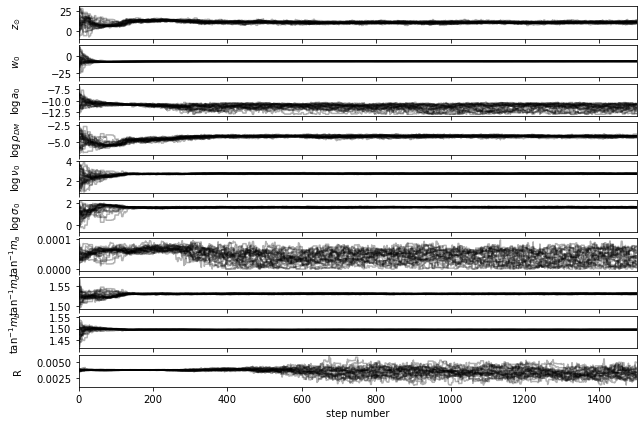

In [618]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0
# labels = [r"$z_{\odot}$", r"$w_{0}$", r"$\log a_0$", r"$\log \rho_{DM}$", r"$\log \sigma_{DD}$", 
#           r"$\log h_{DD}$", r"$\log \nu_0$", r"$\log \sigma_0$", r"$\tan^{-1} m_a$", r"$\tan^{-1} m_{\sigma}$",
#           r"$\tan^{-1} m_b$", "R"]

labels = [r"$z_{\odot}$", r"$w_{0}$", r"$\log a_0$", r"$\log \rho_{DM}$", r"$\log \nu_{0}$", 
          r"$\log \sigma_{0}$", r"$\tan^{-1} m_a$", r"$\tan^{-1} m_{\sigma}$", r"$\tan^{-1} m_b$", "R"]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior, 
        args=[data, priors], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(p0, 1500, progress=True)
    end = time.time()
    multi_time = end - start
    plot_chain(sampler, labels)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 50000/50000 [32:17<00:00, 25.81it/s]


Multiprocessing took 1937.2 seconds


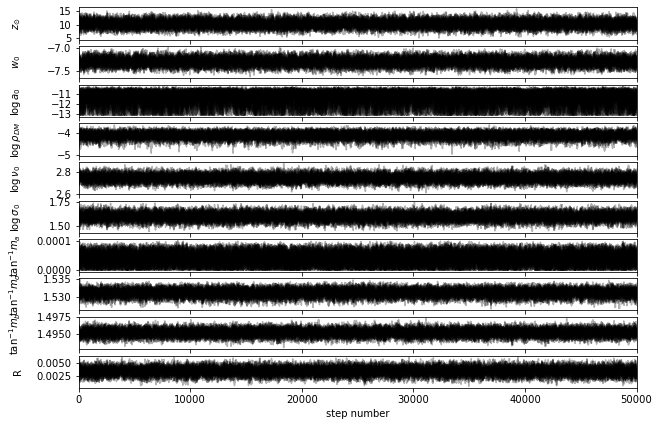

In [623]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior, 
        args=[data, priors], 
        pool=pool
    )
    start = time.time()
    state = sampler.run_mcmc(next_p0, 50000, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    plot_chain(sampler, labels)
    sampler_ = sampler

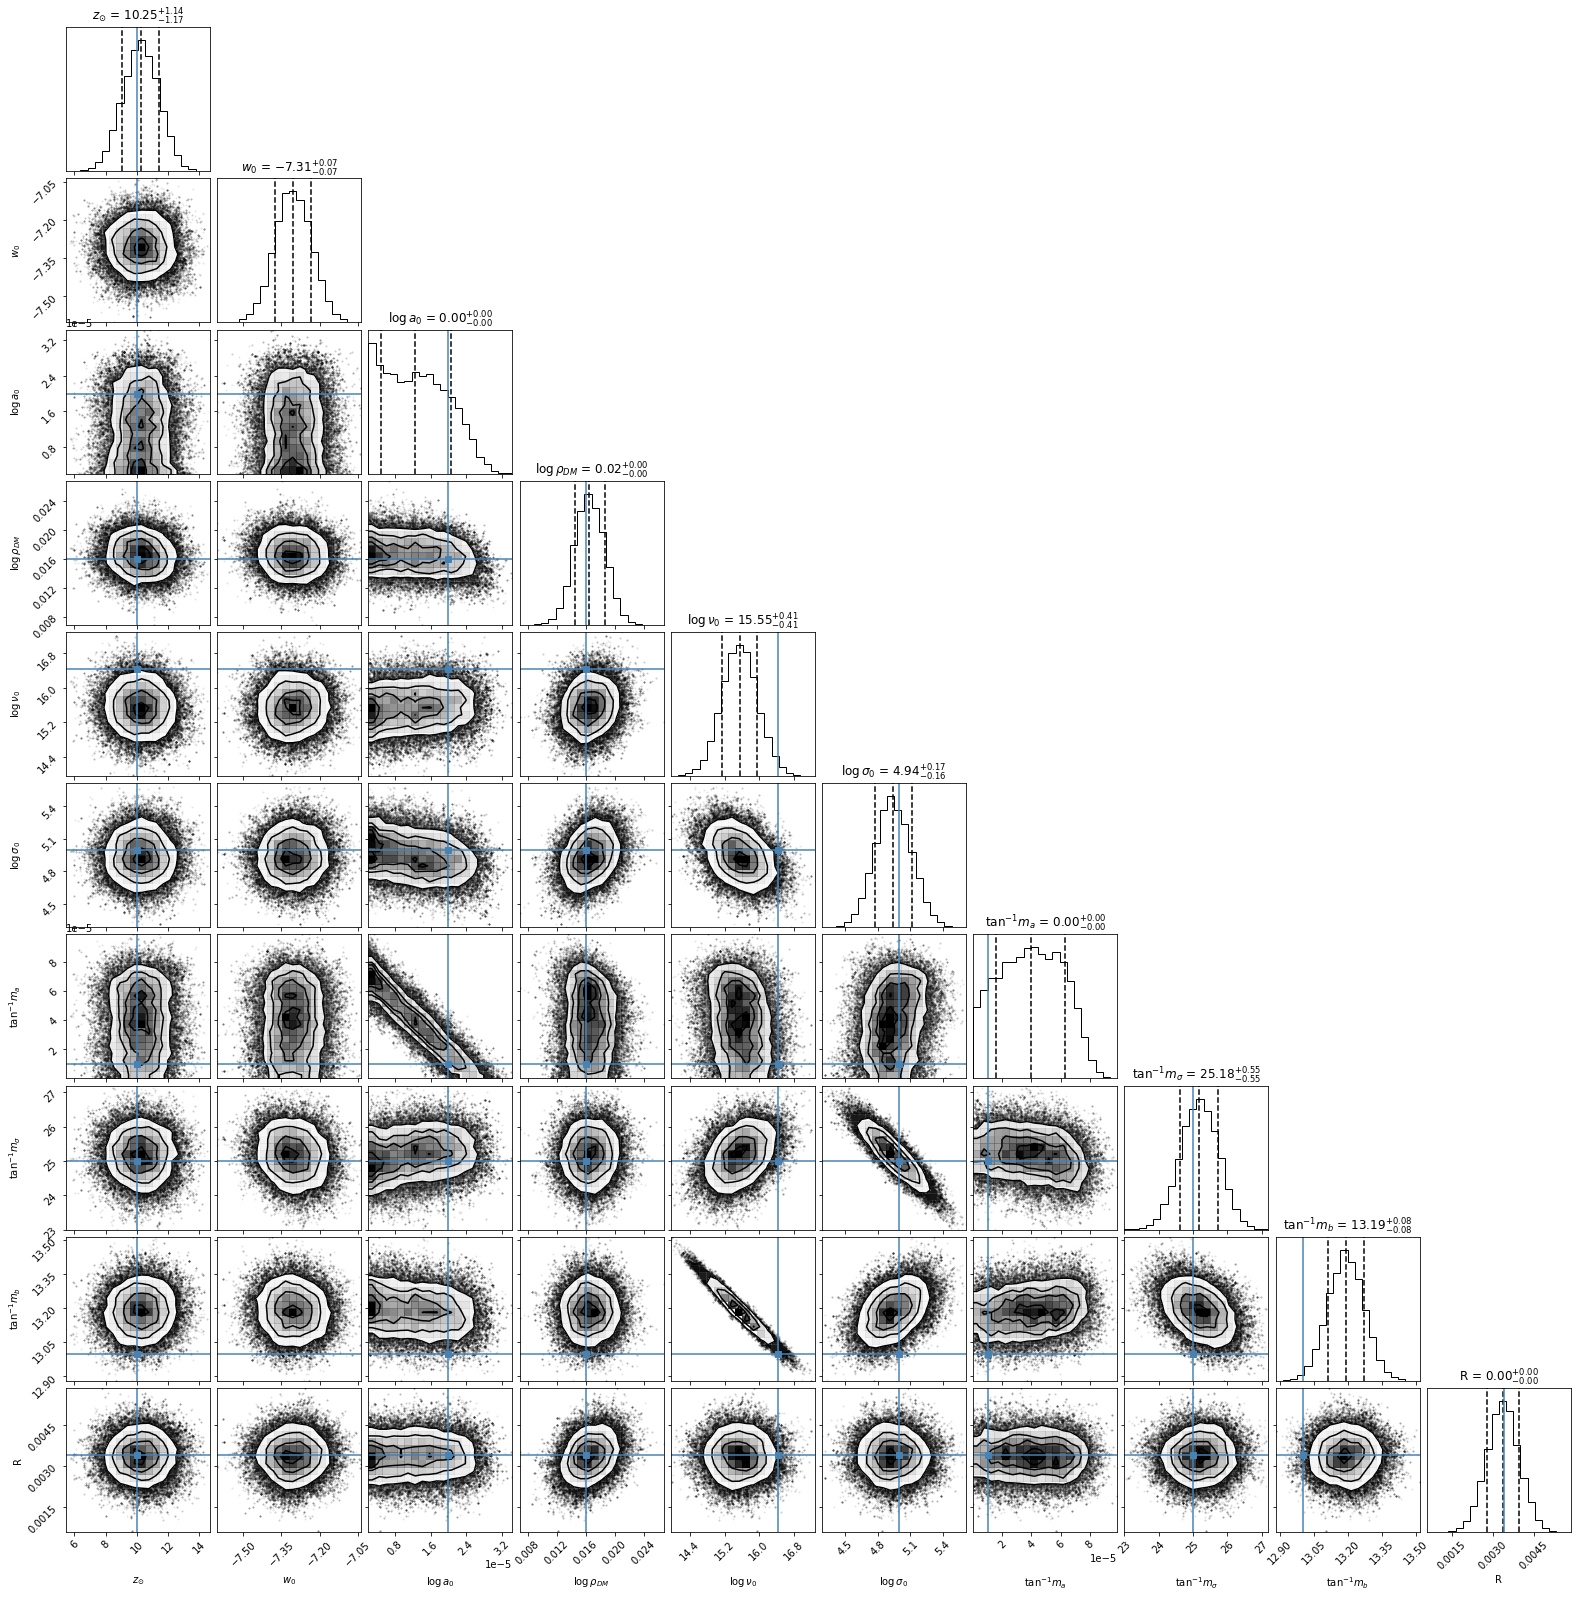

In [622]:
flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples[:, 2:-4] = np.exp(flat_samples[:, 2:-4])
flat_samples[:, -4:-1] = np.tan(flat_samples[:, -4:-1])
fig = corner.corner(
    flat_samples, labels=labels,
    # truths=[zsun, w0, np.log(a0), np.log(rhoDM), np.log(sigmaDD), np.log(hDD), np.log(Nu0), 
    #               np.log(sigma_0), np.arctan(ma), np.arctan(msigma), np.arctan(b), R],
    truths=[zsun, w0, a0, rhoDM, Nu0, sigma_0, ma, msigma, b, R],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)